In [8]:
import pandas as pd
import numpy as np
import glob
import os
import psutil
import GPUtil
import time

gpu = GPUtil.getGPUs()[0]
print(gpu.name)


NVIDIA GeForce RTX 3080 Laptop GPU
['../data/generated/generated_data_2.csv', '../data/generated/generated_data_3.csv', '../data/generated/generated_data_1.csv']
<class 'pandas.core.frame.DataFrame'>
Index: 32404 entries, 0 to 10854
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              32404 non-null  object 
 1   Transaction Category              32404 non-null  object 
 2   Amount                            32404 non-null  float64
 3   Credit/Debit                      32404 non-null  object 
 4   Payment Method                    32404 non-null  object 
 5   Inflation Rate                    32404 non-null  float64
 6   Dependent Family Size             32404 non-null  int64  
 7   Age                               32404 non-null  int64  
 8   Months with Higher Spending       32404 non-null  object 
 9   Number of Expenses a Month        32

In [ ]:

start_time = 0


def log_resource_usage(scenario, timer_end):
    global start_time
    cpu_percent = psutil.cpu_percent(interval=1)
    ram_mb = psutil.virtual_memory().used / (1024 ** 2)
    gpu_usage = gpu.load * 100
    gpu_ram_usage = gpu.memoryUsed
    print(f"{scenario}: CPU Usage: {cpu_percent}%")
    print(f"{scenario}: RAM Usage: {round(ram_mb, 2)} MB")
    print(f"{scenario}: GPU Usage: {round(gpu_usage, 2)}%")
    print(f"{scenario}: GPU RAM Usage: {round(gpu_ram_usage, 2)} MB")
    if timer_end:
        print(
            f"{scenario}: Execution time: {round(time.time() - start_time, 2)} seconds")
        start_time = 0
    elif start_time == 0:
        start_time = time.time()
    return cpu_percent, ram_mb

all_files = glob.glob(os.path.join('../data/generated/' , "generated_*.csv"))
print(all_files)

dataset = pd.DataFrame()
for idx, filename in enumerate(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    dataset = pd.concat([dataset, df])

print(dataset.info())



### Encode the data

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

# Assume df is your DataFrame
X = dataset.drop(['Budget', 'Date', 'Year-Month', 'Credit/Debit', 'Most Frequent Expense Categories',
                 'Months with Higher Spending', 'Number of Expenses a Month', 'Payment Method'], axis=1)  # Features
y = dataset['Budget']  # Labels

# Perform Z-score normalization
numeric_cols = ['Amount', 'Month', 'Year', 'Day', 'Last Month Budget',
                'Cumulative Monthly Spending', 'Average Monthly Budget']

categories = list(X['Transaction Category'].unique())
# for col in numeric_cols:
#     X[col] = (X[col] - X[col].mean()) / X[col].std()

# # If you want to normalize the label as well
# mean_budget = y.mean()
# std_budget = y.std()
# y = (y - mean_budget) / std_budget
# print(mean_budget)
# print(X.info())
# print(y.info())

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)

# # Initialize OneHotEncoder
# onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# # Create ColumnTransformer to apply OneHotEncoding only to the 'Description' column
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('desc_onehot', onehot_encoder, ['Transaction Category'])
#     ],
#     remainder='passthrough'  # keep remaining columns as is
# )

# # Fit and transform the training data and transform testing data
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# X_train_onehot and X_test_onehot now contain the one-hot encoded 'Description' column along with other features.
X['Transaction Category'] = X['Transaction Category'].map(categories.index)
# convert to float32 and int32 for tf
X = X.astype({'Transaction Category': 'int32', 'Amount': 'float32', 'Month': 'int32', 'Year': 'int32', 'Day': 'int32',
             'Last Month Budget': 'float32', 'Cumulative Monthly Spending': 'float32', 'Average Monthly Budget': 'float32',
             'Inflation Rate': 'float32', 'Dependent Family Size': 'int32', 'Age': 'int32', 'Estimated Monthly Expenses': 'int32'})
y = y.astype('float32')

print(X.info())
print(y.info())


<class 'pandas.core.frame.DataFrame'>
Index: 32404 entries, 0 to 10854
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction Category         32404 non-null  int32  
 1   Amount                       32404 non-null  float32
 2   Inflation Rate               32404 non-null  float32
 3   Dependent Family Size        32404 non-null  int32  
 4   Age                          32404 non-null  int32  
 5   Estimated Monthly Expenses   32404 non-null  int32  
 6   Day                          32404 non-null  int32  
 7   Month                        32404 non-null  int32  
 8   Year                         32404 non-null  int32  
 9   Cumulative Monthly Spending  32404 non-null  float32
 10  Last Month Budget            32404 non-null  float32
 11  Average Monthly Budget       32404 non-null  float32
dtypes: float32(5), int32(7)
memory usage: 1.7 MB
None
<class 'pandas.core.series.Se

In [10]:
from budget_predictor import Model

NUM_EPOCHS = 100
BATCH_SIZE = 100

X_tensor_data = tf.constant(X)
X_tensor_data = tf.cast(X_tensor_data, tf.float32)
print(X_tensor_data.shape)


y_tensor_data = tf.constant(y)
y_tensor_data = tf.cast(y_tensor_data, tf.float32)
y_tensor_data = tf.expand_dims(y_tensor_data, axis = -1)
print(y_tensor_data.shape)


epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((X_tensor_data, y_tensor_data))
train_ds = train_ds.batch(X.size)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('model.ckpt')

(32404, 12)
(32404, 1)
Tensor("sequential_3/output/BiasAdd:0", shape=(None, 1), dtype=float32)
Tensor("y:0", shape=(None, 1), dtype=float32)
Tensor("sequential_3/output/BiasAdd:0", shape=(None, 1), dtype=float32)
Tensor("y:0", shape=(None, 1), dtype=float32)
Finished 10 epochs
  loss: 11391339520.000
Finished 20 epochs
  loss: 1626372096.000
Finished 30 epochs
  loss: 2555666176.000
Finished 40 epochs
  loss: 1725837056.000
Finished 50 epochs
  loss: 1564294656.000
Finished 60 epochs
  loss: 1560565632.000
Finished 70 epochs
  loss: 1502003200.000
Finished 80 epochs
  loss: 1499548544.000
Finished 90 epochs
  loss: 1484469120.000
Finished 100 epochs
  loss: 1476316544.000


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'model.ckpt'>}

In [12]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

Tensor("sequential_3/output/BiasAdd:0", shape=(None, 1), dtype=float32)
Tensor("y:0", shape=(None, 1), dtype=float32)
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
2023-09-21 22:56:59.578748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-21 22:56:59.578851: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-21 22:56:59.581863: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_model
2023-09-21 22:56:59.584227: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-21 22:56:59.584255: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_model
2023-09-21 22:56:59.589701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-21 22:56:59.591655: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-21 22:56:59.659154: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedMo

In [13]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

INFO: Created TensorFlow Lite delegate for select TF ops.
2023-09-21 22:57:41.295464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-21 22:57:41.295557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 16 nodes with 0 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
logits_original = m.infer(x=X_tensor_data[:1])['logits'][0]
logits_lite = infer(x=X_tensor_data[:1])['logits'][0]

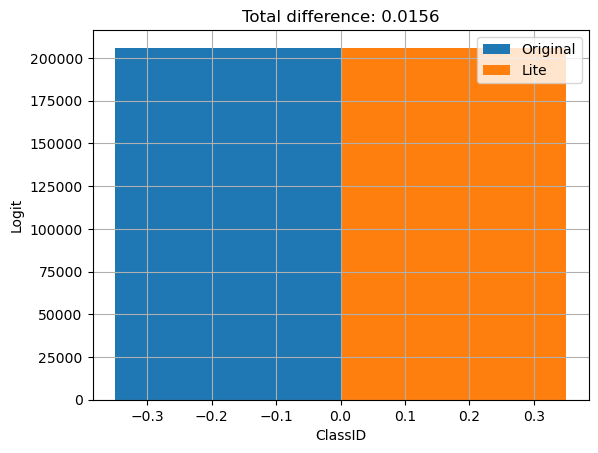

In [16]:
import matplotlib.pyplot as plt

def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras_tuner.tuners import RandomSearch

# Assume preprocessed X_train_transformed, X_test_transformed, y_train, y_test

# Standardize the data
scaler_x = StandardScaler().fit(X_train_transformed)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_x.transform(X_train_transformed)
X_test_scaled = scaler_x.transform(X_test_transformed)
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print((X_train_scaled.shape[1],))

# Define the hypermodel
def build_hypermodel(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=256, step=32),
                    activation='relu',
                    input_shape=(X_train_scaled.shape[1],),
                    
                    ))
    # model.add(Dropout(rate=hp.Float('input_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Additional hidden layer with regularization
    # model.add(Dense(units=hp.Int('hidden_units', min_value=32, max_value=128, step=32),
    #                 activation='relu',
    #                 kernel_regularizer=l1_l2(l1=hp.Float('l1_value', min_value=1e-5, max_value=1e-2, sampling='LOG'),
    #                                          l2=hp.Float('l2_value', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    #                 ))
    # model.add(Dropout(rate=hp.Float('hidden_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer='adam',
                  loss='mean_squared_error')
    
    return model


# Initialize the tuner
tuner = RandomSearch(
    build_hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=5
)

# Perform hyperparameter search
tuner.search(X_train_scaled, y_train_scaled, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters and train it on the data
best_model = tuner.hypermodel.build(best_hp)
log_resource_usage("Pre Training", False)
best_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)
log_resource_usage("Post Training", True)

# Evaluate the model
y_pred_scaled = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)

print(f'Best Hyperparameters: {best_hp.values}')
print(f'Mean Squared Error with Best Hyperparameters: {mse}')

### Test the model

In [ ]:
new_data = pd.DataFrame({
    'Amount': [1800],
    'Transaction Category': ['transport'],
    'Year': [2019],
    'Month': [5],
    'Day': [15],
    'Age': [25],
    'Inflation Rate': [0.03],
    'Dependent Family Size': [3],
    'Last Month Budget': [197000],
    'Estimated Monthly Expenses': [200000],
    'Cumulative Monthly Spending': [56000],
    'Average Monthly Budget': [110000]
})


In [ ]:

# Transform the new data point in the same way as the training data
new_data_transformed = preprocessor.transform(new_data)
new_data_scaled = scaler_x.transform(new_data_transformed)  # Scale the features

# Predict the Budget using the trained neural network model
predicted_budget_scaled = best_model.predict(new_data_scaled)

# Inverse scale the predicted Budget
predicted_budget = scaler_y.inverse_transform(predicted_budget_scaled)

print(predicted_budget)

print(f'Predicted budget: {round(predicted_budget[0][0], 2)}')
